# Scan MERRA-2 atmospheric properties during one Year
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update April 25th 2018
- update June 5th 2019 for Python3 and Pic du Midi
- update Auxtel December 2nd 2022

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.

## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


Bad key axes.color_cycle in file templates/matplotlibrc, line 215 ('axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key keymap.all_axes in file templates/matplotlibrc, line 393 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os

def default_proj_lib():
    proj_lib = os.getenv('PROJ_LIB')
    if proj_lib not in (None, 'PROJ_LIB'):
        return proj_lib
    try:
        import conda
    except ImportError:
        conda = None
    if conda is not None or os.getenv('CONDA_PREFIX') is None:
        conda_file_dir = conda.__file__
        conda_dir = conda_file_dir.split('lib')[0]
        proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
        if os.path.exists(proj_lib):
            return proj_lib
        return None
    return None


In [6]:
theprojlib=default_proj_lib()
print("The PROJ_LIB={}".format(theprojlib))

The PROJ_LIB=/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/share/proj


In [7]:
#os.environ["PROJ_LIB"] = theprojlib
#print os.environ["PROJ_LIB"]

In [8]:
# Do conda update --all

In [9]:
import os
import re
import numpy as np
#from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [10]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [11]:
import h5py

In [12]:
import libGMAOMERRA2Data as merra2  # My own library

In [13]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [14]:
YEARNUM="2021"

In [15]:
# SELECT OBSERVATORY
OBS_NAME='lsst'

In [16]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"
# For Simulation of CTIO atmosphere in May-Jun 2017
#HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"
# Data 2018
#HDFEOS_ZOO_DIR="/sps/lsst/data/MERRA2/M2I1NXASM.5.12.4/"+YEARNUM
#HDFEOS_ZOO_DIR="/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/"+YEARNUM
#HDFEOS_ZOO_DIR=os.path.join("/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4",YEARNUM)
HDFEOS_ZOO_DIR=os.path.join("/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM",YEARNUM)
#HDFEOS_ZOO_DIR=os.path.join("/Users/dagoret/DATA/merra-2import/M2I1NXASM.5.12.4",YEARNUM)

In [17]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [18]:
DATA_TAG=['PS','T10M','T2M','TO3','TOX','TQI','TQL','TQV','TS','U10M','U2M','U50M','V10M','V2M','V50M' ]

In [19]:
DATA_TITLE=['Surface Pressure',
            '10 meter air temperature',
            '2 meter air temperature',
            'total column ozone',
            'total column odd oxygen',
            'total precipitable ice water',
            'total precipitable liquid water',
            'total precipitable water vapor',
            'Surface Temperature skin',
            '10 meter eastward wind',
            '2 meter eastward wind',
            '50 meter eastward wind',
            '10 meter northward wind',
            '2 meter northward wind',
            '50 meter northward wind'
           ]

In [20]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [21]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # 

In [22]:
pandas_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [23]:
fits_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [24]:
hdf5_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.h5'

In [25]:
# 15 output files for figures
figfile_ps='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ps'+'.jpg'
figfile_t10='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t10'+'.jpg'
figfile_t2='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t2'+'.jpg'
figfile_to3='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_to3'+'.jpg'
figfile_tox='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tox'+'.jpg'
figfile_tqi='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqi'+'.jpg'
figfile_tql='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tql'+'.jpg'
figfile_tqv='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqv'+'.jpg'
figfile_ts='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ts'+'.jpg'
figfile_u10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u10m'+'.jpg'
figfile_u2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u2m'+'.jpg'
figfile_u50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u50m'+'.jpg'
figfile_v10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v10m'+'.jpg'
figfile_v2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v2m'+'.jpg'
figfile_v50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v50m'+'.jpg'

In [26]:
# 15 output files for figures
figfile_ps='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ps'+'.png'
figfile_t10='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t10'+'.png'
figfile_t2='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t2'+'.png'
figfile_to3='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_to3'+'.png'
figfile_tox='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tox'+'.png'
figfile_tqi='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqi'+'.png'
figfile_tql='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tql'+'.png'
figfile_tqv='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqv'+'.png'
figfile_ts='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ts'+'.png'
figfile_u10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u10m'+'.png'
figfile_u2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u2m'+'.png'
figfile_u50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u50m'+'.png'
figfile_v10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v10m'+'.png'
figfile_v2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v2m'+'.png'
figfile_v50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v50m'+'.png'

### Select where in the world

In [27]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [28]:
loc

(-70.7366833333333, -30.240741666666672, 2749.999999999238)

### 2.2) Getting the list of the files
------------------------------

In [29]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [30]:
nc4_files[:5]

['MERRA2_400.inst1_2d_asm_Nx.20210407.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20211006.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20210106.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20210524.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20210525.nc4']

### 2.3) Select files of a given month

In [31]:
#keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2018.*'

In [32]:
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.'+YEARNUM+'.*'

In [33]:
print('Selection key' ,keysel_filename)

Selection key ^MERRA2_400.inst1_2d_asm_Nx.2021.*


In [34]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [35]:
nc4_files2

array(['MERRA2_400.inst1_2d_asm_Nx.20210407.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20211006.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210106.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210524.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210525.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210115.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210319.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210227.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210214.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210404.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210213.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210421.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210416.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210417.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20211031.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20211121.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210317.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20211217.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20211104.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20210206.nc4',


### 2.4) Sort files by increasing time

In [36]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [37]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [38]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]  # intermediate data series
ts4=[]
ts5=[]
ts6=[]  # intermediate data series
ts7=[]
ts8=[]
ts9=[]  # intermediate data series
ts10=[]
ts11=[]
ts12=[]
ts13=[]
ts14=[]

df_inst1_2d_asm_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    print(file)
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
    
    # with python3 obliged to transform byte string into a string    
    m_un_tim2=m_un_tim.decode("utf-8")  
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim2) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    

    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

        elif index==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index==5:
            ts5 = pd.Series(dt, index=time_rng)
        elif index==6:
            ts6 = pd.Series(dt, index=time_rng)
            
        elif index==7:
            ts7 = pd.Series(dt, index=time_rng)
        elif index==8:
            ts8 = pd.Series(dt, index=time_rng)
        elif index==9:
            ts9 = pd.Series(dt, index=time_rng)            
            
        elif index==10:
            ts10 = pd.Series(dt, index=time_rng)
        elif index==11:
            ts11 = pd.Series(dt, index=time_rng)
        elif index==12:
            ts12 = pd.Series(dt, index=time_rng) 
            
        elif index==13:
            ts13 = pd.Series(dt, index=time_rng) 
        elif index==14:
            ts14 = pd.Series(dt, index=time_rng) 
            
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5,
                       DATA_TAG[6]: ts6,                       

                       DATA_TAG[7]: ts7,
                       DATA_TAG[8]: ts8,
                       DATA_TAG[9]: ts9,
                       
                       DATA_TAG[10]: ts10,
                       DATA_TAG[11]: ts11,
                       DATA_TAG[12]: ts12,
                       DATA_TAG[13]: ts13,
                       DATA_TAG[14]: ts14 }, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210101.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210102.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210103.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210104.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210105.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210106.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210107.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210108.nc4
/sps/lsst/groups/auxtel/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2021/MERRA2_400.inst1_2d_asm_Nx.20210109.nc4
/sps/lsst/groups/auxtel/MERRA2/data/i

### Concatenation

In [39]:
df_inst1_2d_asm_Nx=pd.concat(df_inst1_2d_asm_Nx)

In [40]:
df_inst1_2d_asm_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5832 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PS      5832 non-null   float32
 1   T10M    5832 non-null   float32
 2   T2M     5832 non-null   float32
 3   TO3     5832 non-null   float32
 4   TOX     5832 non-null   float32
 5   TQI     5832 non-null   float32
 6   TQL     5832 non-null   float32
 7   TQV     5832 non-null   float32
 8   TS      5832 non-null   float32
 9   U10M    5832 non-null   float32
 10  U2M     5832 non-null   float32
 11  U50M    5832 non-null   float32
 12  V10M    5832 non-null   float32
 13  V2M     5832 non-null   float32
 14  V50M    5832 non-null   float32
dtypes: float32(15)
memory usage: 387.3 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [41]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_inst1_2d_asm_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in {}".format(DATA_TITLE[index],OBS_NAME,YEARNUM)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Pressure

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families we

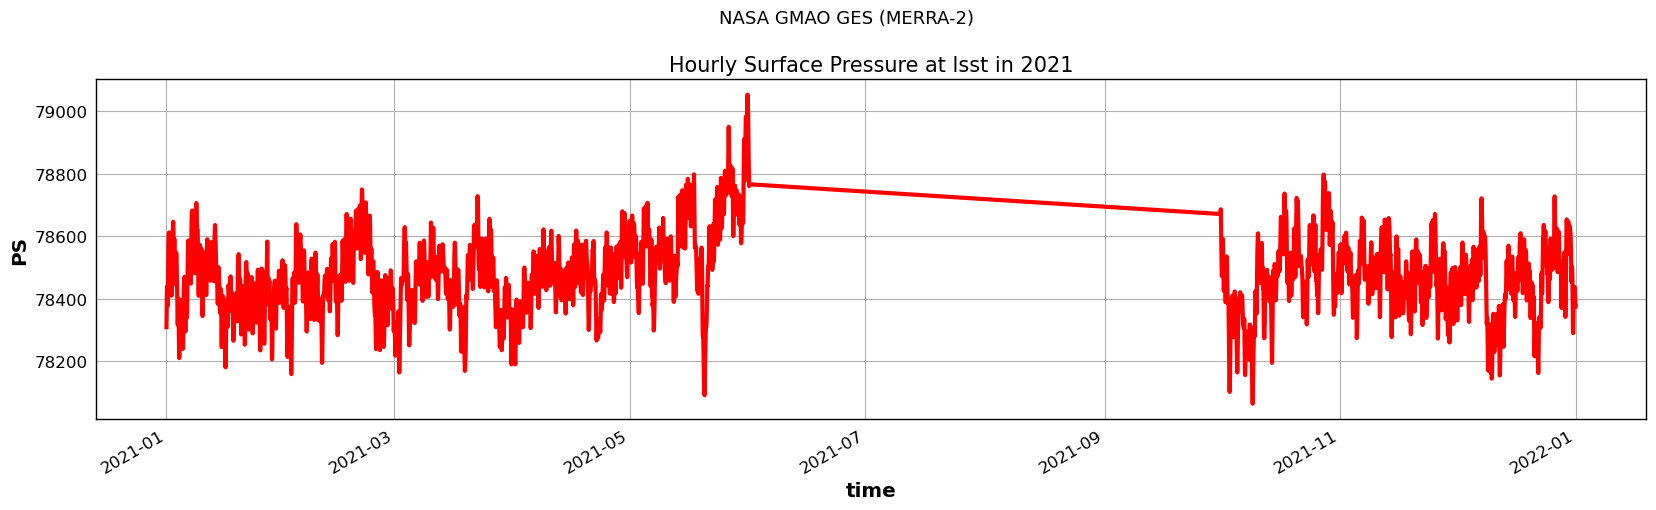

In [42]:
PlotTimeSeries(0,figfile_ps)

###  4.2)  T10
----------------

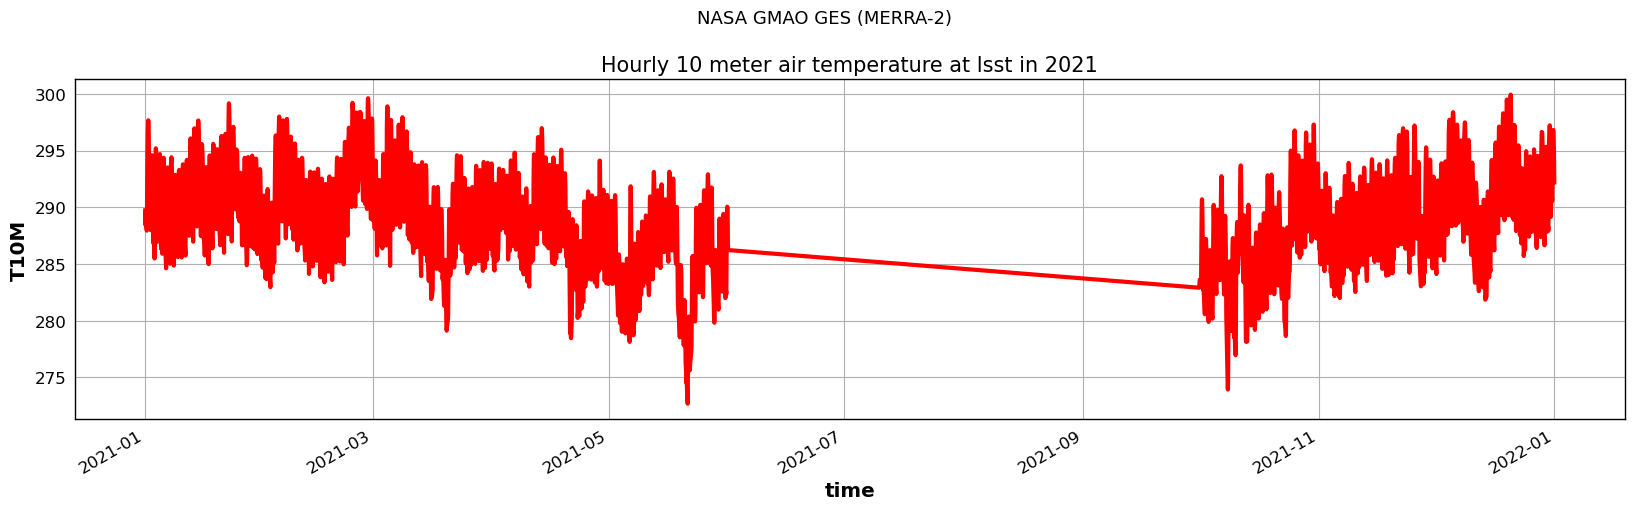

In [43]:
PlotTimeSeries(1,figfile_t10)

### 4.3) t2

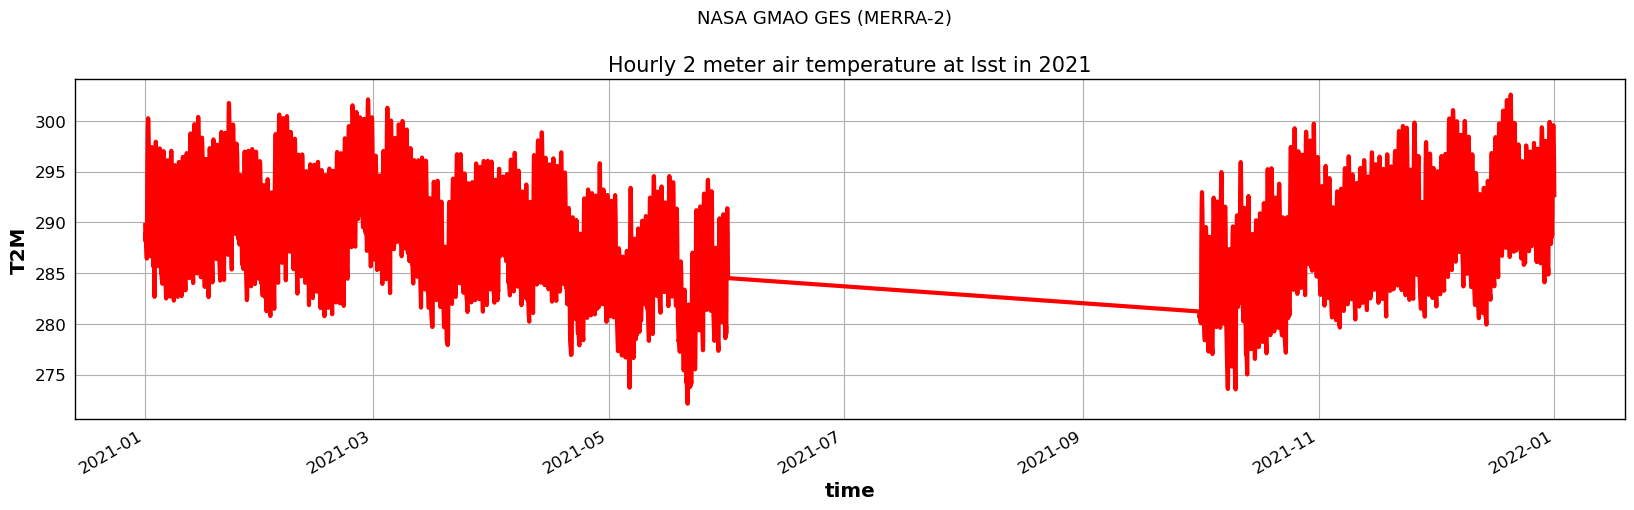

In [44]:
PlotTimeSeries(2,figfile_t2)

### 4.4) to3

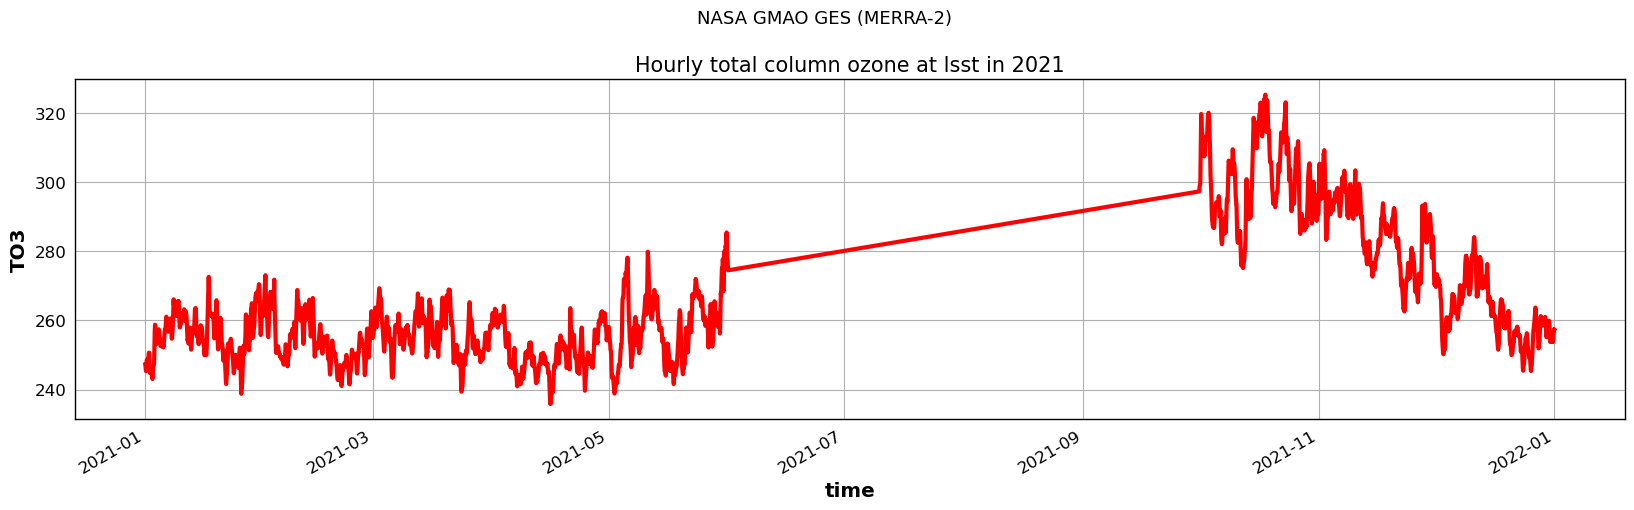

In [45]:
PlotTimeSeries(3,figfile_to3)

### 4.5) tox

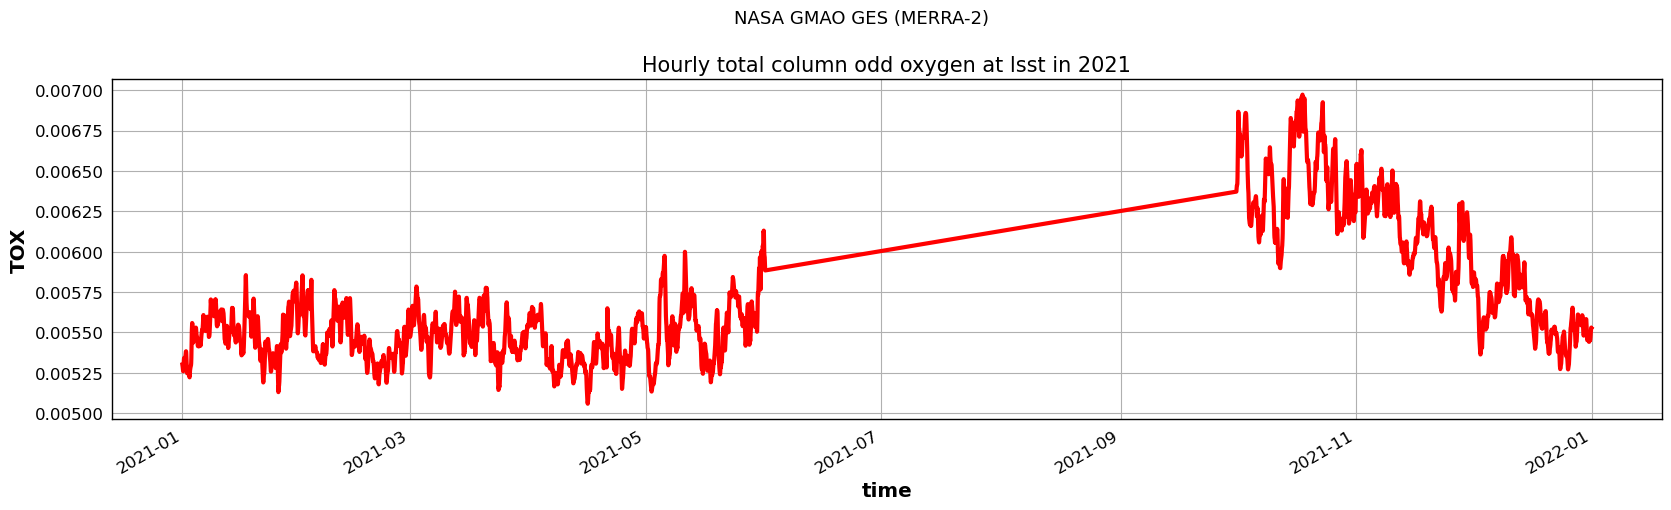

In [46]:
PlotTimeSeries(4,figfile_tox)

### 4.6 TQI

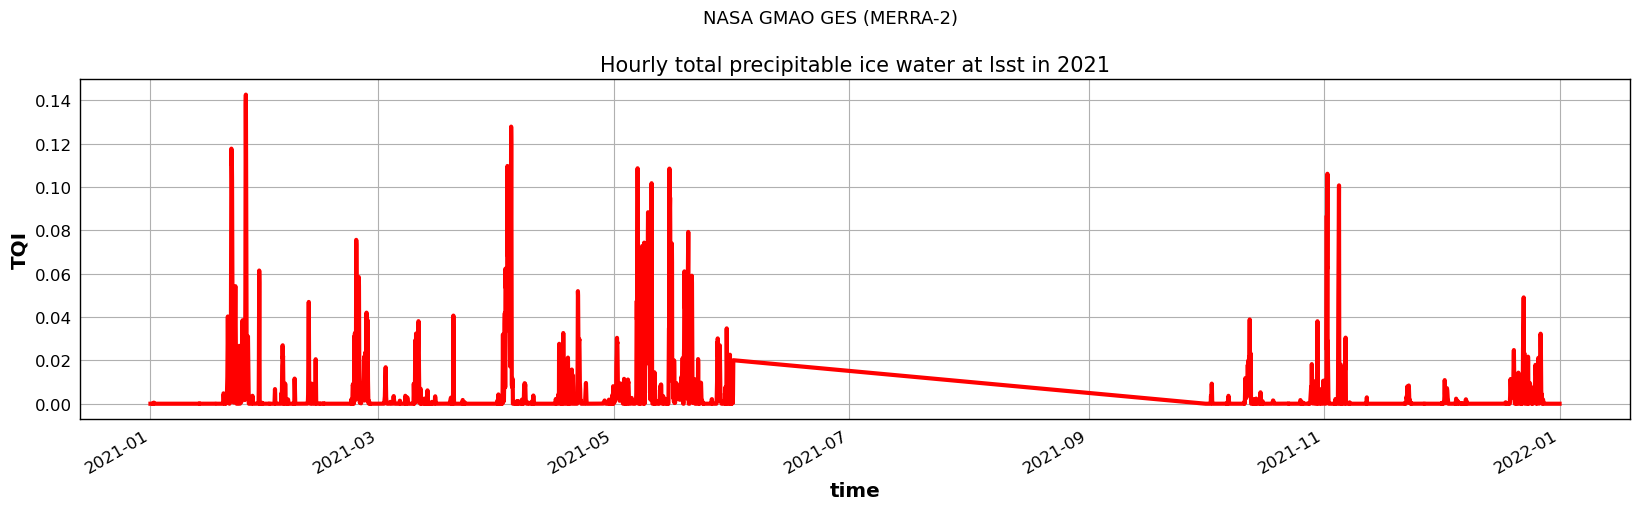

In [47]:
PlotTimeSeries(5,figfile_tqi)

### 4.7) TQL

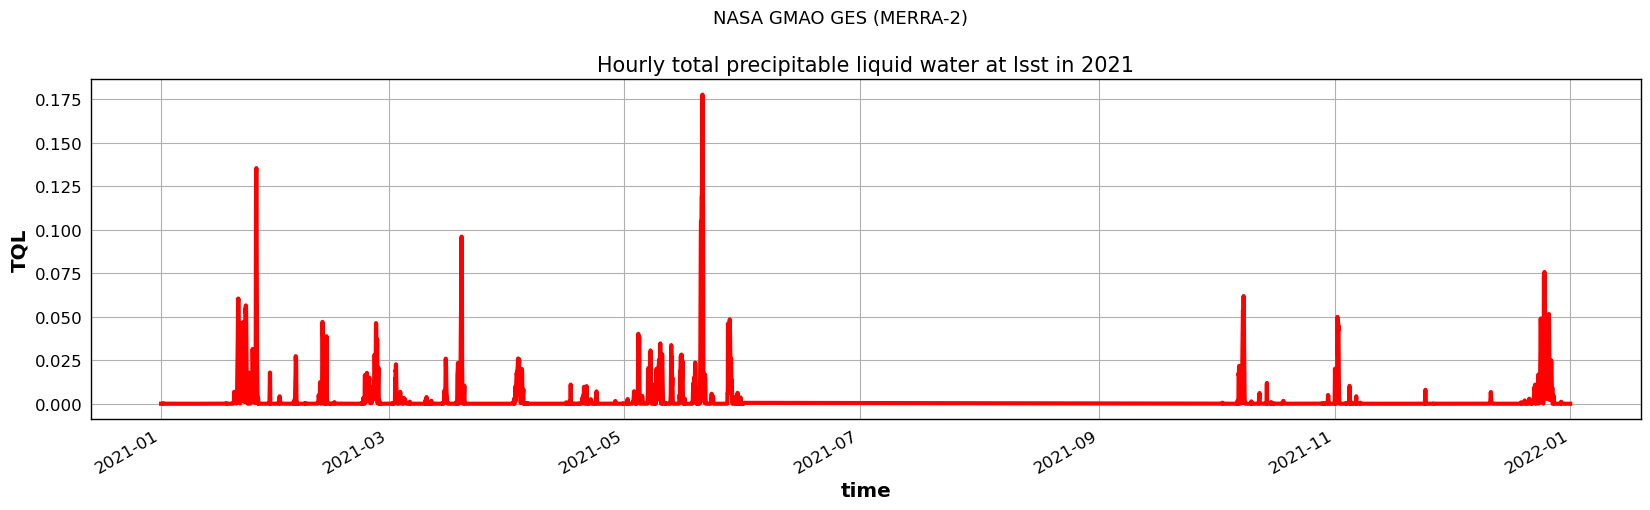

In [48]:
PlotTimeSeries(6,figfile_tql)

### TQV

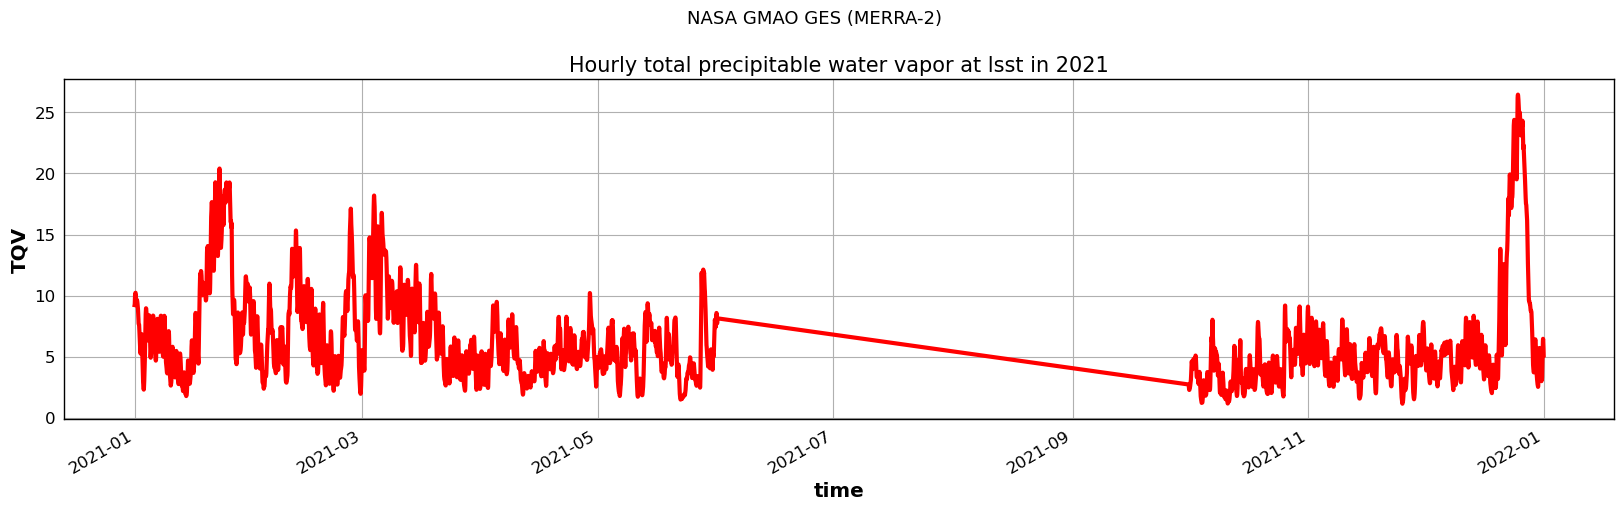

In [49]:
PlotTimeSeries(7,figfile_tqv)

### 4.8) TS

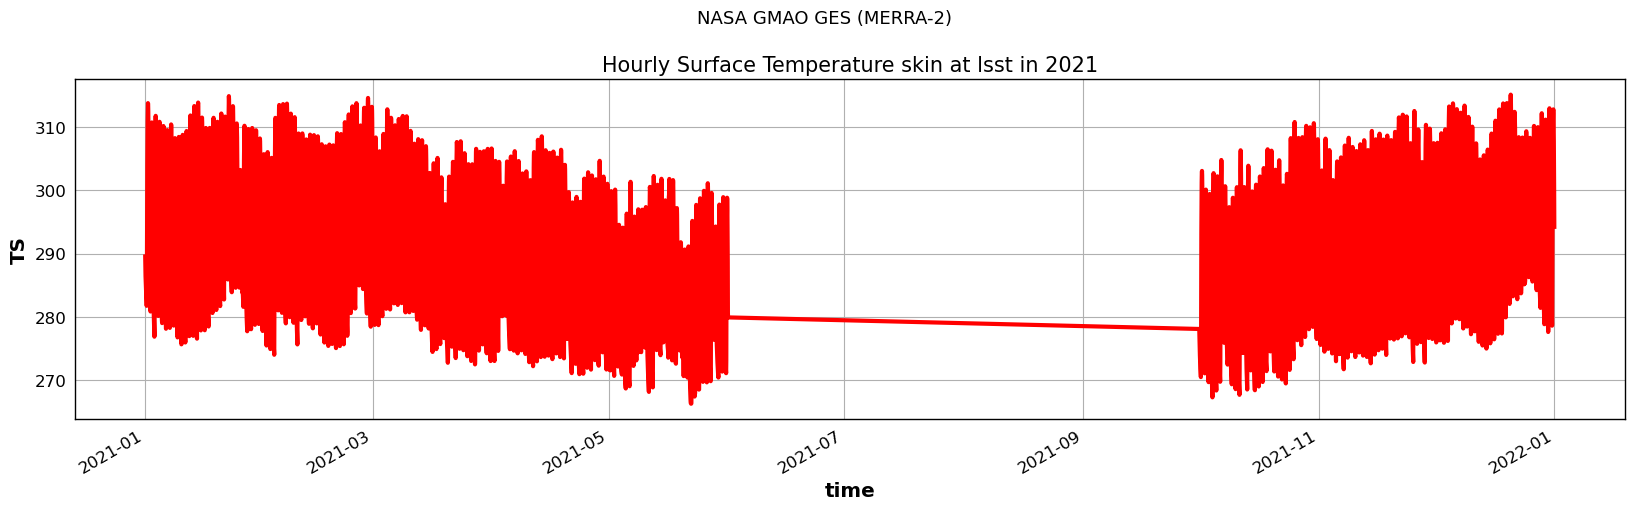

In [50]:
PlotTimeSeries(8,figfile_ts)

### 4.9) um10

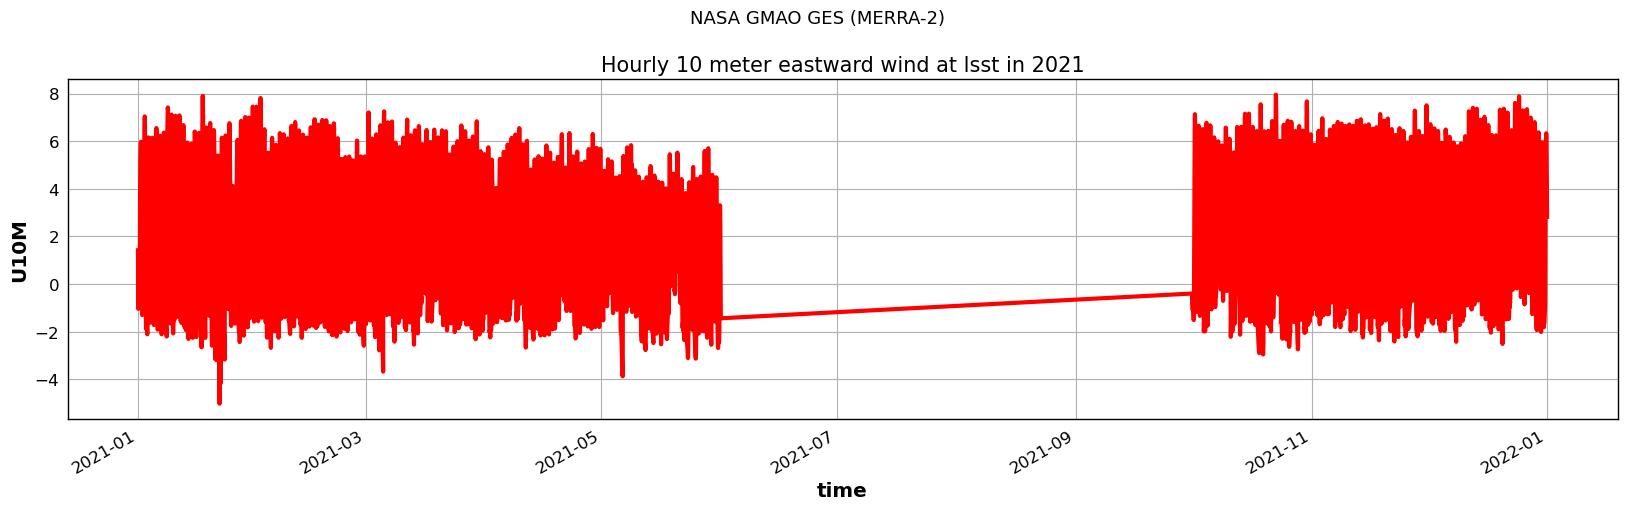

In [51]:
PlotTimeSeries(9,figfile_u10m)

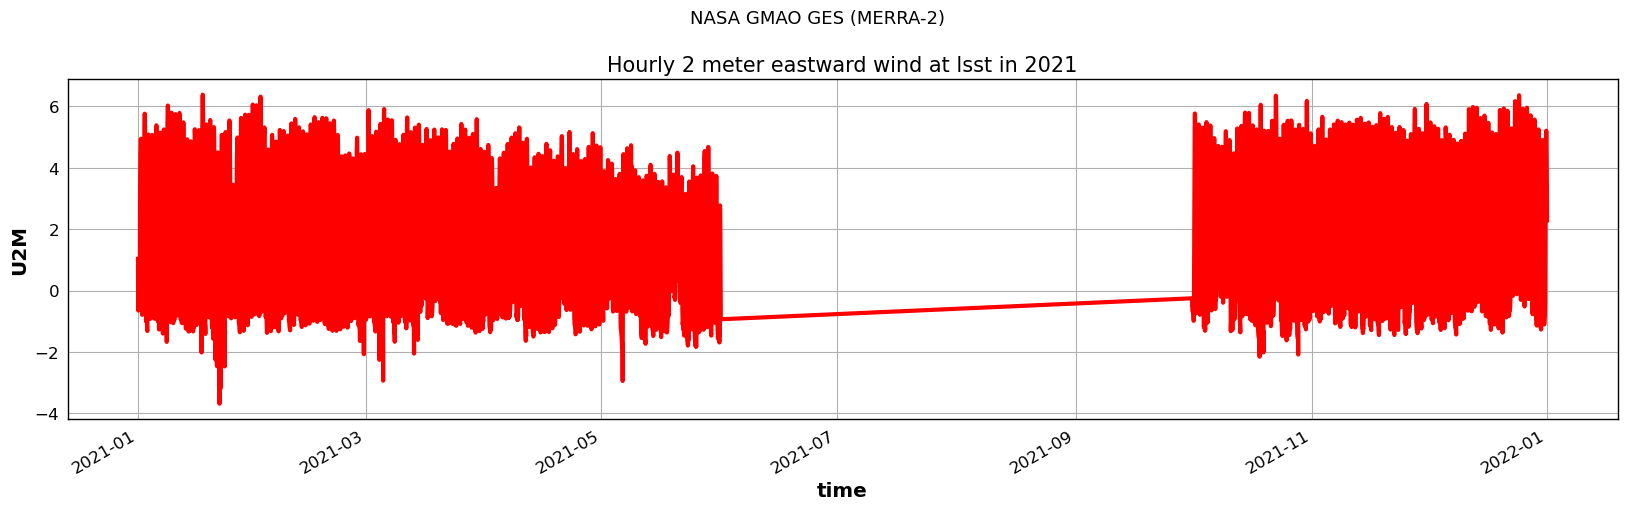

In [52]:
PlotTimeSeries(10,figfile_u2m)

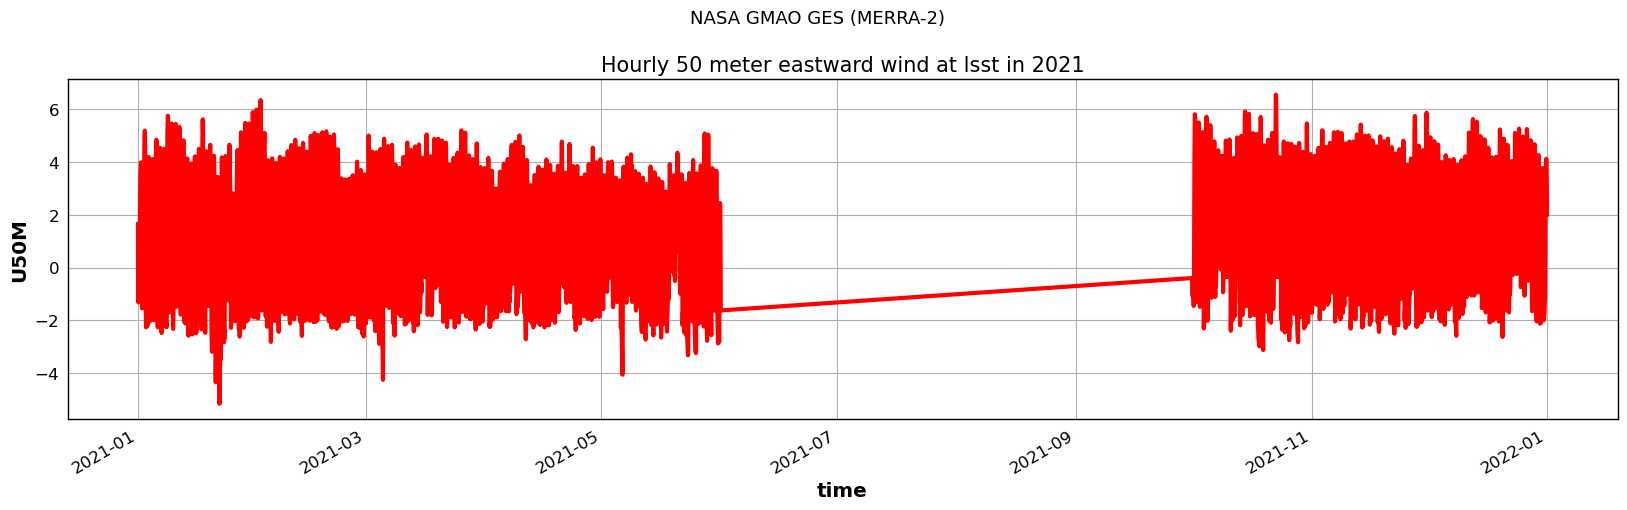

In [53]:
PlotTimeSeries(11,figfile_u50m)

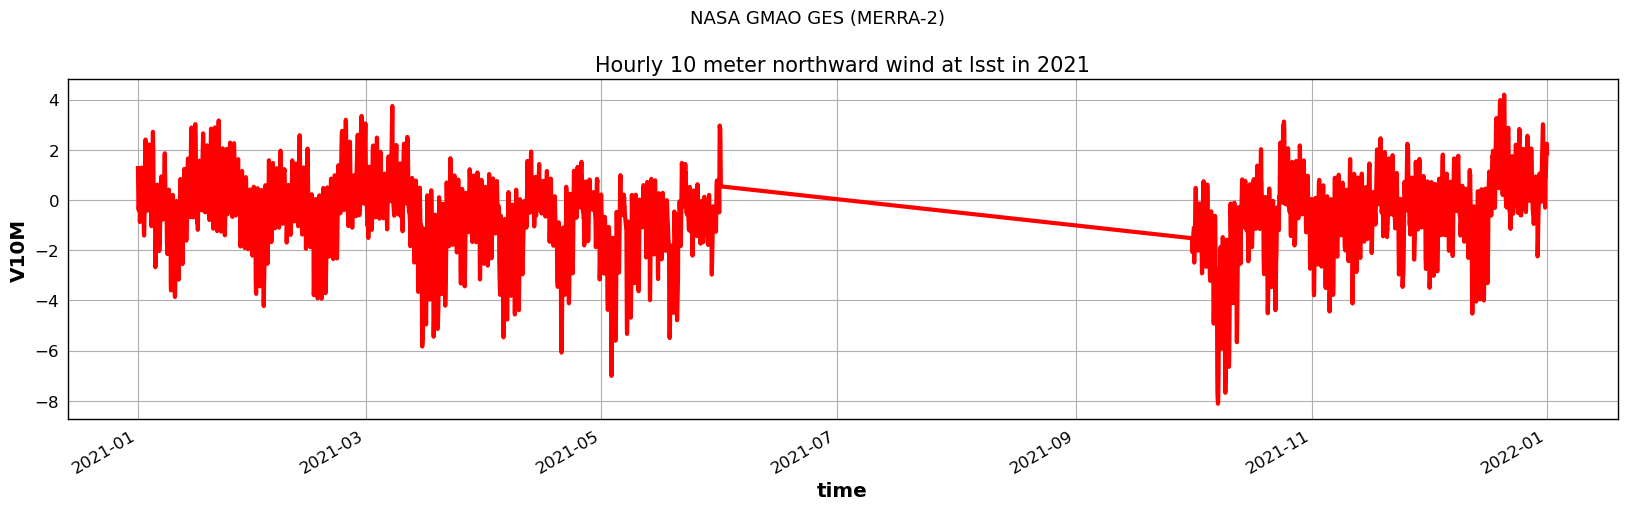

In [54]:
PlotTimeSeries(12,figfile_v10m)

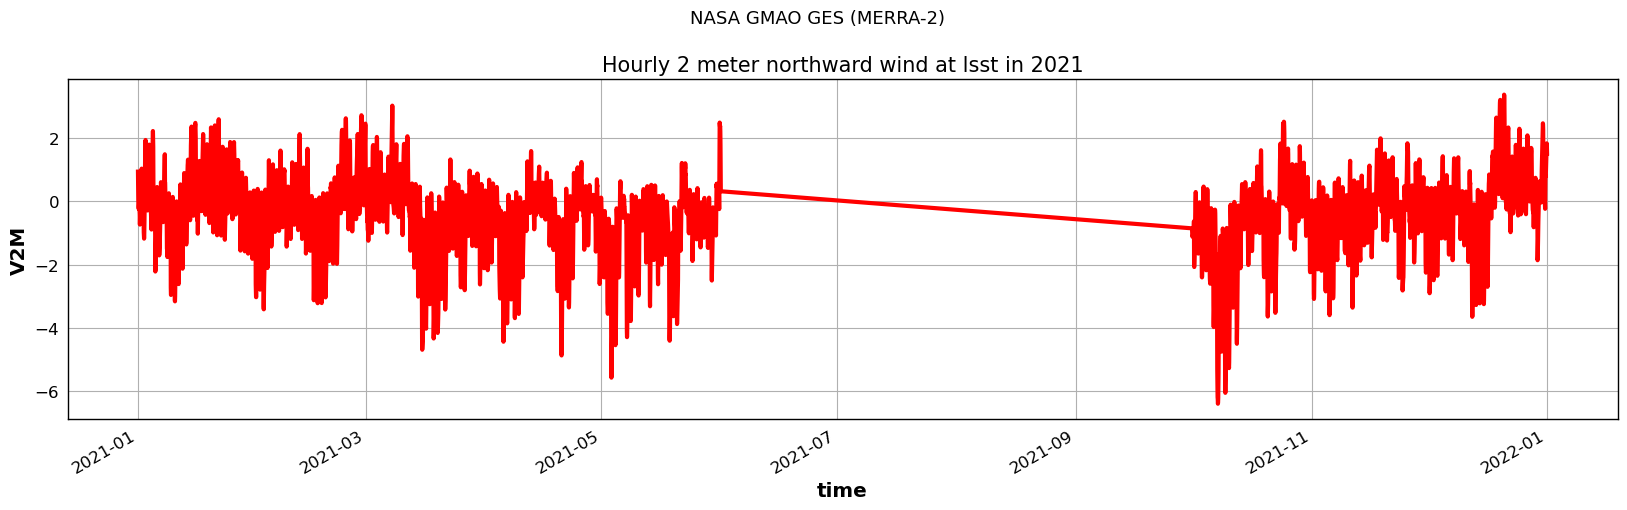

In [55]:
PlotTimeSeries(13,figfile_v2m)

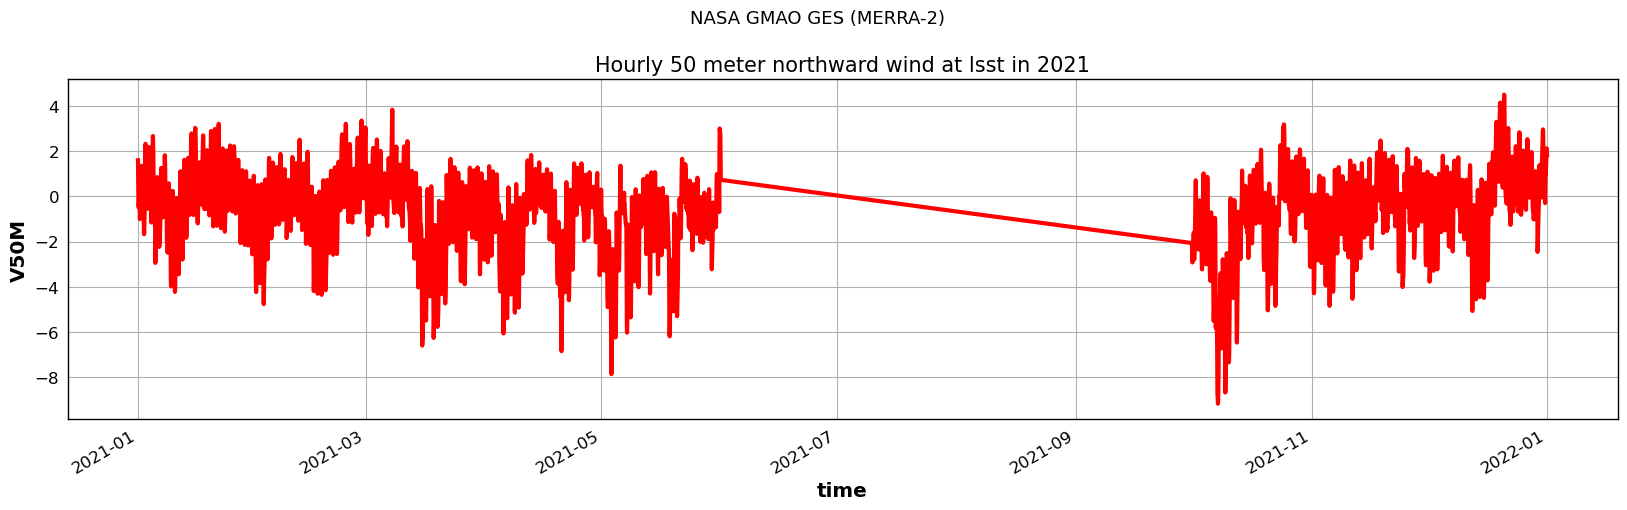

In [56]:
PlotTimeSeries(14,figfile_v50m)

## 5) Output

In [57]:
df_inst1_2d_asm_Nx.index.name='time'
df_inst1_2d_asm_Nx.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000
mean,78477.281250,288.509369,288.262207,265.552460,0.005699,0.003628,0.002631,6.224353,289.227936,1.471854,1.318212,0.863002,-0.639829,-0.462270,-0.845316
std,124.123642,4.426883,5.898872,18.675205,0.000401,0.011938,0.010704,3.870956,12.285639,3.093342,2.410538,2.469651,1.511324,1.186094,1.736959
min,78064.265625,272.677734,272.132843,235.901489,0.005058,0.000000,0.000000,1.140266,266.327332,-5.025660,-3.685153,-5.161845,-8.114434,-6.394870,-9.170275
25%,78401.259766,285.493927,283.753319,252.289352,0.005415,0.000000,0.000000,3.757872,278.644577,-1.322315,-0.826289,-1.432673,-1.285021,-0.894462,-1.654083
50%,78474.476562,288.271164,287.603058,259.449326,0.005567,0.000000,0.000000,5.212664,286.126373,0.264161,0.170220,0.287826,-0.511315,-0.339349,-0.659594
75%,78550.832031,291.761475,293.109360,274.803108,0.005898,0.000515,0.000042,7.389340,300.459045,4.549982,3.738354,3.249953,0.162750,0.113854,0.149184
max,79053.585938,299.943298,302.585388,325.246490,0.006973,0.142700,0.177673,26.455482,315.059967,7.956434,6.378519,6.558074,4.198710,3.375812,4.494401


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [58]:
dataset=df_inst1_2d_asm_Nx

In [59]:
dataset.index.name='time'

In [60]:
dataset.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000
mean,78477.281250,288.509369,288.262207,265.552460,0.005699,0.003628,0.002631,6.224353,289.227936,1.471854,1.318212,0.863002,-0.639829,-0.462270,-0.845316
std,124.123642,4.426883,5.898872,18.675205,0.000401,0.011938,0.010704,3.870956,12.285639,3.093342,2.410538,2.469651,1.511324,1.186094,1.736959
min,78064.265625,272.677734,272.132843,235.901489,0.005058,0.000000,0.000000,1.140266,266.327332,-5.025660,-3.685153,-5.161845,-8.114434,-6.394870,-9.170275
25%,78401.259766,285.493927,283.753319,252.289352,0.005415,0.000000,0.000000,3.757872,278.644577,-1.322315,-0.826289,-1.432673,-1.285021,-0.894462,-1.654083
50%,78474.476562,288.271164,287.603058,259.449326,0.005567,0.000000,0.000000,5.212664,286.126373,0.264161,0.170220,0.287826,-0.511315,-0.339349,-0.659594
75%,78550.832031,291.761475,293.109360,274.803108,0.005898,0.000515,0.000042,7.389340,300.459045,4.549982,3.738354,3.249953,0.162750,0.113854,0.149184
max,79053.585938,299.943298,302.585388,325.246490,0.006973,0.142700,0.177673,26.455482,315.059967,7.956434,6.378519,6.558074,4.198710,3.375812,4.494401


In [61]:
dataset.head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2021-01-01 00:00:00,78309.335938,289.735870,289.729065,247.261139,0.005301,0.0,0.0,9.219856,289.536713,1.417040,1.029335,1.653588,1.271824,0.941790,1.593075
2021-01-01 01:00:00,78353.437500,288.458313,288.148193,246.954041,0.005294,0.0,0.0,9.299347,287.697388,-0.640781,-0.321693,-0.997959,0.720388,0.370704,1.075519
2021-01-01 02:00:00,78399.140625,289.096069,288.326019,246.628021,0.005287,0.0,0.0,9.733832,286.420502,-1.040606,-0.651973,-1.313788,0.071793,0.050780,0.098654
2021-01-01 03:00:00,78434.101562,289.615845,288.912292,246.087036,0.005275,0.0,0.0,10.086275,285.643829,-0.592623,-0.392119,-0.690463,-0.301546,-0.178987,-0.397412
2021-01-01 04:00:00,78439.296875,289.578674,288.793030,245.581268,0.005264,0.0,0.0,10.178970,284.947937,-0.186442,-0.133778,-0.234019,-0.381485,-0.213192,-0.497831


### write pandas

In [62]:
dataset.to_csv(pandas_filename)

### write hdf5

In [63]:
# Not working
#dataset.to_hdf(hdf5_filename,key='df',mode="w")

### Check

In [64]:
saved_dataset=pd.read_csv(pandas_filename)

In [65]:
saved_dataset.head()

,time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
0,2021-01-01 00:00:00,78309.336,289.73587,289.72906,247.26114,0.005301,0.0,0.0,9.219856,289.53670,1.417040,1.029335,1.653588,1.271824,0.941790,1.593075
1,2021-01-01 01:00:00,78353.440,288.45830,288.14820,246.95404,0.005294,0.0,0.0,9.299347,287.69740,-0.640781,-0.321693,-0.997959,0.720388,0.370704,1.075519
2,2021-01-01 02:00:00,78399.140,289.09607,288.32602,246.62802,0.005287,0.0,0.0,9.733832,286.42050,-1.040606,-0.651973,-1.313788,0.071793,0.050780,0.098654
3,2021-01-01 03:00:00,78434.100,289.61584,288.91230,246.08704,0.005275,0.0,0.0,10.086275,285.64383,-0.592623,-0.392119,-0.690463,-0.301546,-0.178987,-0.397412
4,2021-01-01 04:00:00,78439.300,289.57867,288.79303,245.58127,0.005264,0.0,0.0,10.178970,284.94794,-0.186442,-0.133778,-0.234019,-0.381485,-0.213192,-0.497831


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [66]:
table = Table.from_pandas(saved_dataset)

In [67]:
table

time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2021-01-01 00:00:00,78309.336,289.73587,289.72906,247.26114,0.005300526,0.0,0.0,9.219856,289.5367,1.4170398,1.0293348,1.6535876,1.2718236,0.9417901,1.5930753
2021-01-01 01:00:00,78353.44,288.4583,288.1482,246.95404,0.0052940515,0.0,0.0,9.299347,287.6974,-0.6407808,-0.32169294,-0.9979588,0.7203878,0.37070394,1.0755193
2021-01-01 02:00:00,78399.14,289.09607,288.32602,246.62802,0.005287072,0.0,0.0,9.733832,286.4205,-1.0406063,-0.65197265,-1.3137883,0.07179281,0.05077979,0.098653704
2021-01-01 03:00:00,78434.1,289.61584,288.9123,246.08704,0.0052754744,0.0,0.0,10.086275,285.64383,-0.5926235,-0.39211863,-0.6904633,-0.3015461,-0.17898667,-0.39741215
2021-01-01 04:00:00,78439.3,289.57867,288.79303,245.58127,0.005264479,0.0,0.0,10.17897,284.94794,-0.18644208,-0.1337778,-0.2340188,-0.3814854,-0.21319231,-0.49783134
2021-01-01 05:00:00,78423.164,289.1218,288.33444,245.31262,0.0052588126,0.0,0.0,10.217963,284.18936,-0.18961197,-0.14275587,-0.2345767,-0.39810467,-0.24168992,-0.47803444
2021-01-01 06:00:00,78396.98,288.53876,287.64148,245.51111,0.0052631223,0.0,0.0,10.226756,283.45566,-0.37677467,-0.2583961,-0.46641874,-0.25338197,-0.1642282,-0.29829556
2021-01-01 07:00:00,78377.74,288.21292,287.18936,246.25739,0.0052790577,0.0,0.0,10.087981,282.81403,-0.76432633,-0.5222938,-0.9111241,-0.08499837,-0.042478383,-0.10995942
2021-01-01 08:00:00,78381.0,288.1411,286.97864,247.30212,0.0053014904,0.0,0.00015181303,9.84174,282.24316,-0.8429761,-0.5729843,-0.99497116,-0.10102475,-0.047557533,-0.12742862


In [68]:
table.write(fits_filename,format='fits',overwrite=True)